In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import helper as hp
from bitstring import BitArray, BitStream
import os
plt.style.use('classic')

def getSize(filename):
    st = os.stat(filename)
    return st.st_size

### Load Image

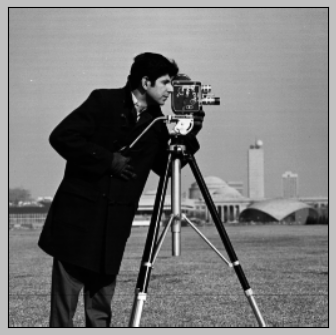

In [8]:
img = cv.imread('./cameraman.tif', 0)
rows, cols = img.shape
img = np.float32(img)
hp.show(img)

## Part - 1

### Compute DCT matrix

In [15]:
# *******************************************Generates the DCT matrix*******************************************
def getDCT(n):
    x = np.arange(0, n, 1, np.float32)
    y = np.arange(0, n, 1, np.float32)

    cc,rr = np.meshgrid(x, y)
    c = np.sqrt(2/n) * np.cos(np.pi * (2*cc + 1) * rr / (2 * n))
    c[0,:] = c[0,:] / np.sqrt(2)
    
    return c;

# *******************************************Generates the quantization matrix********************************
def quantMat(a, b, c, d):
    mat = np.float32(
                    [[d,d,a,a,b,b,b,b],
                     [d,d,a,a,b,b,b,b],
                     [a,a,a,a,b,b,b,b],
                     [a,a,a,a,b,b,b,b],
                     [b,b,b,b,c,c,c,c],
                     [b,b,b,b,c,c,c,c],
                     [b,b,b,b,c,c,c,c],
                     [b,b,b,b,c,c,c,c]]
          );
    return mat;

# ******************************************Computes DCT Transform*******************************************
def DCT_transf(img, a, b, c, d):
    # Center image intensity
    img_cen = img - np.ones(img.shape, np.float32) * 127.0

    BLK_SIZE = 8;
    num_rows = int(np.floor(rows / BLK_SIZE))
    num_cols = int(np.floor(cols / BLK_SIZE))
    Y = np.empty(img.shape, np.int16)
    Q = quantMat(a,b,c,d);
    DCT = getDCT(BLK_SIZE)
    
    # Iterate over all blocks
    for i in range(num_rows):
        for j in range(num_cols):
            x = img_cen[i*8 : i*8 + 8, j*8 : j*8 + 8]
            x = DCT @ x @ DCT.T
            y = np.floor((x / Q) + 0.5)
            Y[i*8 : i*8 + 8, j*8 : j*8 + 8] = y
            
    return Y


# *******************************************Computes inverse DCT*******************************************
def inverseDCT(rec_data, a, b, c, d):
    Z = np.empty(img.shape, np.float32)
    Q = quantMat(a,b,c,d);
    BLK_SIZE = 8;
    num_rows = int(np.floor(rows / BLK_SIZE))
    num_cols = int(np.floor(cols / BLK_SIZE))
    DCT = getDCT(BLK_SIZE)

    for i in range(num_rows):
        for j in range(num_cols):
            x = rec_data[i*8 : i*8 + 8, j*8 : j*8 + 8]
            x = x * Q;
            y = DCT.T @ x @ DCT
            Z[i*8 : i*8 + 8, j*8 : j*8 + 8] = y
            
    Z = Z + 127
    return Z;

# *******************************************Encodes a number (helper function)*****************************
def encodeNumber(num):
    if(num == 0):
        code = BitArray('0b0');
        return code;
    
    n = 1
    abs_num = abs(num)
    while(abs_num >= 2**n):
        n = n + 1

    ind = -1;
    if (num > 0):
        ind = int(num);
    else:
        ind = int(2**(n) - 1 + num)
    
    code = BitArray();
    code.append('0b' + '1'*n + '0')
    code.append('uint:' + str(n) + '=' + str(ind))
    return code

# *******************************************Encodes the entire Image*******************************************
def encodeImage(img):
    coded_img = ''
    
    count_zero = 0;
    
    for i in range(rows):
        for j in range(cols):
            y = img[i,j]
            if( encodeNumber(y).bin == '0'):
                count_zero += 1
            coded_img = coded_img + encodeNumber(y).bin
            
#     print('encode count', count_zero)
    return coded_img

# *******************************************Decodes a bitstring to a number************************************
def decodeNumber(n, ind_str):
    ind = BitArray('0b0' + ind_str).int
    if ind >= 2**(n-1):
        return ind
    else:
        return ind - (2**n - 1)

# *******************************************Decodes the entire bitstring*******************************************
def decodeImage(data):
    reconst_vec = []
    i = 0;
    
    while ( i < len(data)):
        num = -1;
        n = 0;
        while(data[i] == '1'):
            n = n + 1
            i = i + 1

        assert (data[i] == '0'), 'Data Corrupted (Assertion failed)'

        if (n != 0):
            i = i + 1;
            ind_str = data[i:i+n]
            num = decodeNumber(n, ind_str)
            i = i + n;
        else:
            i = i + 1
            num = 0

        reconst_vec.append(num)

    rec_data = np.reshape(reconst_vec, img.shape)
    return rec_data


encode count 55794
104486 521920
Compression Ratio 4.995118963306089
MSE 38.7004623413


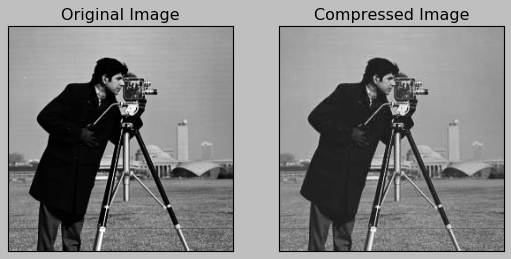

In [12]:
# Computing DCT of Image
img_dct1 = DCT_transf(img,20,40,100,10)

# Encoding Image
coded_img1 = encodeImage(img_dct1)

# Writing the bitstring to a file
f = open('encoded_cameraman', 'w')
f.write(coded_img1)
f.close()

# Computing Compression ratio
comp_size1  = len(coded_img1);
org_size1   = getSize('./cameraman.tif')*8
comp_ratio1 = org_size1 / comp_size1
print(comp_size1, org_size1)
print('Compression Ratio', comp_ratio1)

# Reading the encoded Image
data = '' 
with open('encoded_cameraman', 'r') as myfile:
    data=myfile.read().replace('\n', '')

# Decoding the Image
img_dec1 = decodeImage(data)

# Computing Inverse DCT
img_uncomp1 = inverseDCT(img_dec1,20,40,100,10)

print('MSE', hp.getMSE(img, img_uncomp1))
hp.subShow(1,2,1, img, 'Original Image')
hp.subShow(1,2,2, img_uncomp1, 'Compressed Image')
plt.savefig('./Images/p1a.png', dpi= 200, bbox_inches='tight', transparent=True),
plt.show()

#### Part - 2

In [313]:
def DCT_transf2(img, a, b, c, d):
    # Center image intensity
    img_cen = img - 127.0

    BLK_SIZE = 8;
    num_rows = int(np.floor(rows / BLK_SIZE))
    num_cols = int(np.floor(cols / BLK_SIZE))
    Y = np.empty(img.shape, np.int16)
    Q = quantMat(a,b,c,d);
    DCT = getDCT(BLK_SIZE)
    
    # Iterate over all blocks
    for i in range(num_rows):
        for j in range(num_cols):
            x = img_cen[i*8 : i*8 + 8, j*8 : j*8 + 8]
            x = DCT @ x @ DCT.T
            y = np.rint(x)
            Y[i*8 : i*8 + 8, j*8 : j*8 + 8] = y
            
    return Y

def inverseDCT2(rec_data, a, b, c, d):
    Z = np.empty(img.shape, np.int16)
    Q = quantMat(a,b,c,d);
    num_rows = int(rows/BLK_SIZE)
    num_cols = int(cols/BLK_SIZE)
    
    DCT = getDCT(BLK_SIZE)

    for i in range(num_rows):
        for j in range(num_cols):
            x = rec_data[i*8 : i*8 + 8, j*8 : j*8 + 8]
            y = DCT.T @ x @ DCT
            y = np.rint(y)
            Z[i*8 : i*8 + 8, j*8 : j*8 + 8] = y
            
    Z = Z + 127
    return Z;

encode count 10345
382052 521920
Compression Ratio 1.3660967616973605
MSE 0.0831298828125


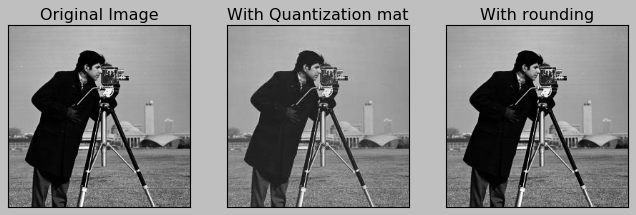

In [349]:
# Computing DCT of the image
img_dct2 = DCT_transf2(img,20,40,100,10)

# Encoding the Image
coded_img2 = encodeImage(img_dct2)
f = open('encoded_cameraman', 'w')
f.write(coded_img2)
f.close()

# Computing Compression ratio
comp_size  = len(coded_img2);
org_size   = getSize('./cameraman.tif')*8
comp_ratio = org_size / comp_size
print(comp_size, org_size)
print('Compression Ratio', comp_ratio)

# Reading the encoded Image
data = '' 
with open('encoded_cameraman', 'r') as myfile:
    data=myfile.read().replace('\n', '')

# Decoding the Image
img_dec2 = decodeImage(data)

# Computing inverse DCT
img_uncomp2 = inverseDCT2(img_dec2,20,40,100,10)
print('MSE', hp.getMSE(img_uncomp2, img))

plt.rcParams["figure.figsize"] = (10,6)
hp.subShow(1,3,1, img, 'Original Image')
hp.subShow(1,3,2, img_uncomp1, 'With Quantization mat')
hp.subShow(1,3,3, img_uncomp2, 'With rounding')
plt.savefig('./Images/p1b.png', dpi= 200, bbox_inches='tight', transparent=False),
plt.show()

## Part - 3

### Trying different values of a, b, and c

In [17]:
val_list = np.linspace(10, 100, 10)
a_min, b_min, c_min, mse_min = None, None, None, 1e20;

for a in val_list:
    for b in val_list:
        for c in val_list:
            img_dct = DCT_transf(img, a,b,c,10)
            coded_img = encodeImage(img_dct)
            
            if(len(coded_img) <= comp_size1):
                img_dec = inverseDCT(img_dct, a,b,c,10);
                mse = hp.getMSE(img, img_dec)

                if(mse < mse_min):
                    a_min, b_min, c_min = a,b,c
                    mse_min = mse

    print('.', end="")

print()
print('Best value of a,b,c:', a_min, b_min, c_min)

..........
Best value of a,b,c: 40.0 30.0 30.0


#### Using optimal value of a, b, and c 

103786 521920
Compression Ratio 5.028809280635153
MSE 32.5271224976


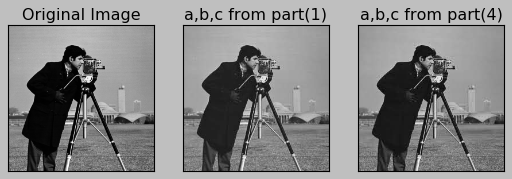

In [22]:
# Computing DCT transform
img_dct = DCT_transf(img, a_min, b_min, c_min, 10)

# Encoding the Image
coded_img3 = encodeImage(img_dct)
f = open('encoded_cameraman', 'w')
f.write(coded_img3)
f.close()

# Computing Compression ratio
comp_size  = len(coded_img3);
org_size   = getSize('./cameraman.tif')*8
comp_ratio = org_size / comp_size
print(comp_size, org_size)
print('Compression Ratio', comp_ratio)

# Reading the encoded Image
data = '' 
with open('encoded_cameraman', 'r') as myfile:
    data=myfile.read().replace('\n', '')

# Decoding the Image
img_dec3 = decodeImage(data)

# Computing inverse DCT
img_uncomp3 = inverseDCT(img_dec3, a_min, b_min, c_min,10)
print('MSE', hp.getMSE(img_uncomp3, img))

hp.subShow(1,3,1, img, 'Original Image')
hp.subShow(1,3,2, img_uncomp1, 'a,b,c from part(1)')
hp.subShow(1,3,3, img_uncomp3, 'a,b,c from part(4)')
plt.savefig('./Images/p1c.png', dpi= 200, bbox_inches='tight', transparent=False),
plt.show()

88360 521920
Compression Ratio 5.90674513354459
MSE 118.959136963


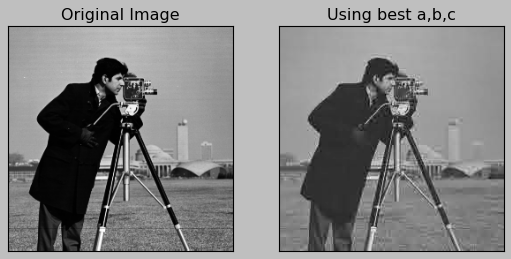

In [19]:
# Computing DCT transform
a_try, b_try, c_try = 100,100,100

img_dct = DCT_transf(img, a_try, b_try, c_try, 10)

# Encoding the Image
coded_img3 = encodeImage(img_dct)
f = open('encoded_cameraman', 'w')
f.write(coded_img3)
f.close()

# Computing Compression ratio
comp_size  = len(coded_img3);
org_size   = getSize('./cameraman.tif')*8
comp_ratio = org_size / comp_size
print(comp_size, org_size)
print('Compression Ratio', comp_ratio)

# Reading the encoded Image
data = '' 
with open('encoded_cameraman', 'r') as myfile:
    data=myfile.read().replace('\n', '')

# Decoding the Image
img_dec3 = decodeImage(data)

# Computing inverse DCT
img_uncomp3 = inverseDCT(img_dec3, a_try, b_try, c_try,10)
print('MSE', hp.getMSE(img_uncomp3, img))

hp.subShow(1,2,1, img, 'Original Image')
hp.subShow(1,2,2, img_uncomp3, 'Using best a,b,c')
# plt.savefig('./Images/p1c.png', dpi= 200, bbox_inches='tight', transparent=False),
plt.show()

In [20]:
os.system('say job done')

256